In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FILE = 'travistorrent_11_1_2017.csv'

In [3]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'gh_is_pr',
                                                         'gh_pr_created_at',
                                                         'gh_lang',
                                                         'git_branch',
                                                         'gh_num_commits_in_push',
                                                         'git_prev_commit_resolution_status',
                                                         'tr_prev_build',
                                                         'gh_first_commit_created_at',
                                                         'gh_team_size',         
                                                         'gh_pushed_at',
                                                         'gh_build_started_at',
                                                         'tr_log_num_tests_ok',        
                                                         'tr_log_num_tests_failed' ,   
                                                         'tr_log_num_tests_skipped',
                                                         'gh_sloc',
                                                         'tr_log_bool_tests_failed'],dtype={ 'tr_build_id': np.float32,
                                                                                            'gh_project_name': 'category',
                                                                                            'gh_is_pr': np.bool,
                                                                                            'gh_pr_created_at': 'category',
                                                                                            'gh_lang': 'category',
                                                                                            'git_branch': 'category',
                                                                                            'gh_num_commits_in_push': np.float32,
                                                                                            'git_prev_commit_resolution_status': 'category',
                                                                                            'tr_prev_build': np.float32,
                                                                                            'gh_first_commit_created_at': 'category',
                                                                                            'gh_team_size': np.int32,
                                                                                            'gh_pushed_at': 'category',
                                                                                            'gh_build_started_at': 'category',
                                                                                            'tr_log_num_tests_ok': np.float32,
                                                                                            'tr_log_num_tests_failed': np.float32,
                                                                                            'tr_log_num_tests_skipped': np.float32,
                                                                                            'gh_sloc': np.int32,
                                                                                            'tr_log_bool_tests_failed':np.bool}, encoding='utf-8')


In [7]:
dataset = dataset.loc[dataset['git_branch'] == 'master']
dataset = dataset.dropna(subset=['gh_num_commits_in_push']) #Remove NaN da coluna especificada
dataset['gh_pushed_at'] = pd.to_datetime(dataset.gh_pushed_at)
dataset = dataset.drop_duplicates(['tr_build_id']) # No projeto todo


<font size = 4/>
3 - Projeto abaixo de 1000 linhas serão descartados,projeto possuindo acima de 1000 e menos que 10.000 serão considerados pequenos, projetos possuindo acima de 10.000 linhas e menos que 100.000 serão considerados médios e projetos acima de 100.000 linhas serão considerados grandes.

In [15]:
def size_project(language, sett):
    if(sett == 1): #abaixo de 1000 linhas
        df1 = dataset.loc[(dataset['gh_sloc'] < 1000) & (dataset['gh_lang'] == language)]
        df1 = df1.drop_duplicates(['gh_project_name'])
        #print("Projetos {} abaixo de 1000 linhas: {}".format(language, len(df1.gh_project_name)))  

    if(sett == 2): #acima de 1000 e menos que 10.000
        df2 = dataset.loc[(dataset['gh_sloc'] < 10000)]
        df2 = df2.loc[(df2['gh_sloc'] > 1000) & (df2['gh_lang'] == language)]
        #df2 = df2.drop_duplicates(['gh_project_name']) # Filtro para quantodade de projetos

        #print("Projetos {} acima de 1000 linhas e abaixo de 10.000 : {}".format(language,len(df2.gh_project_name)))
        return(df2)
    
    if(sett == 3): #acima de 10.000 linhas e menos que 100.000
        df3 = dataset.loc[(dataset['gh_sloc'] < 100000)]
        df3 = df3.loc[(df3['gh_sloc'] > 10000) & (df3['gh_lang'] == language)]
        #df3 = df3.drop_duplicates(['gh_project_name']) # Filtro para quantodade de projetos

        #print("Projetos {} acima de 10.000 linhas e abaixo de 100.000 : {}".format(language,len(df3.gh_project_name)))
        return(df3)
    
    if(sett == 4): #acima de 100.000 linhas
        df4 = dataset.loc[(dataset['gh_sloc'] > 100000) & (dataset['gh_lang'] == language)]
        #df4 = df4.drop_duplicates(['gh_project_name']) # Filtro para quantodade de projetos

        #print("Projetos {} acima de 100.000 linhas: {}".format(language,len(df4.gh_project_name)))
        return(df4)        

<font size = 4/>
3.1 Tamanho dos projetos Ruby e Java

In [29]:
# tirar o comentado do metodo para não haver erro
size_project('ruby', 1)
size_project('ruby', 2)
size_project('ruby', 3)
size_project('ruby', 4)
print("\n")
size_project('java', 1)
size_project('java', 2)
size_project('java', 3)
size_project('java', 4)
print("\n")
size_project('javascript', 1)
size_project('javascript', 2)
size_project('javascript', 3)
size_project('javascript', 4)

Projetos ruby abaixo de 1000 linhas: 533
Projetos ruby acima de 1000 linhas e abaixo de 10.000 : 511
Projetos ruby acima de 10.000 linhas e abaixo de 100.000 : 79
Projetos ruby acima de 100.000 linhas: 8


Projetos java abaixo de 1000 linhas: 37
Projetos java acima de 1000 linhas e abaixo de 10.000 : 201
Projetos java acima de 10.000 linhas e abaixo de 100.000 : 191
Projetos java acima de 100.000 linhas: 28


In [16]:
def weekday_frequency(dataframe): #year
    #dataframe = dataframe.loc[dataset.gh_pushed_at.dt.year == year]

    dataframe = dataframe.gh_pushed_at.dt.weekday

    monday  = []
    tuesday  = []
    wednesday = []
    thursday  = []
    friday = []
    saturday = []
    sunday = []

    for date in dataframe:
        if(date == 0):
            monday.append(date)
        elif(date == 1):
            tuesday.append(date)
        elif(date == 2):
            wednesday.append(date)
        elif(date == 3):
            thursday.append(date)
        elif(date == 4):
            friday.append(date)
        elif(date == 5):
            saturday.append(date)
        elif(date == 6):
            sunday.append(date)
            
    #print("\nMonday: {} commits \n Tuesday: {} \n wednesday: {} \n Thursday: {} \n Friday: {} \n Saturday: {}\n Sunday: {}".format(len(monday), len(tuesday), len(wednesday), len(thursday), len(friday), len(saturday), len(sunday)))
      
    return([monday, tuesday, wednesday, thursday, friday, saturday, sunday])

In [17]:
def month_frequency(dataframe): #year
    #dataframe = dataframe.loc[dataset.gh_pushed_at.dt.year == year]

    dataframe = dataframe.gh_pushed_at.dt.month
    
    january = []
    february = []
    march = []
    april = []
    may = []
    june = []
    july = []
    august = []
    september = []
    october = []
    november = []
    december = []
    
 
    for month in dataframe:
        if(month == 1):
            january.append(month)
        elif(month == 2):
            february.append(month)
        elif(month == 3):
            march.append(month)
        elif(month == 4):
            april.append(month)
        elif(month == 5):
            may.append(month)
        elif(month == 6):
            june.append(month)
        elif(month == 7):
            july.append(month)
        elif(month == 8):
            august.append(month)
        elif(month == 9):
            september.append(month)
        elif(month == 10):
            october.append(month)
        elif(month == 11):
            november.append(month)
        elif(month == 12):
            december.append(month)
            
    #print("january:{} \n february:{} \n march:{} \n april:{} \n may:{} \n june:{} \n july:{} \n august:{} \n september:{} \n october:{} \n november:{} \n december:{} ".format(len(january), len(february), len(march), len(april), len(may), len(june), len(july), len(august), len(september), len(october), len(november), len(december)))
    return([january, february, march, april, may, june, july, august, september, october, november, december])

In [18]:
def plot_bar(sett, language,low, medium, high):
    
    # Dados do grafico
    if(sett == 0):
        frequency_low = [len(low[0]),len(low[1]),len(low[2]),len(low[3]),len(low[4]),len(low[5]),len(low[6]),len(low[7]),len(low[8]),len(low[9]),len(low[10]),len(low[11])]
        frequency_medium = [len(medium[0]),len(medium[1]),len(medium[2]),len(medium[3]),len(medium[4]),len(medium[5]),len(medium[6]),len(medium[7]),len(medium[8]),len(medium[9]),len(medium[10]),len(medium[11])]
        frequency_high = [len(high[0]),len(high[1]),len(high[2]),len(high[3]),len(high[4]),len(high[5]),len(high[6]),len(high[7]),len(high[8]),len(high[9]),len(high[10]),len(high[11])]

        labels_list = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
    if(sett == 1):
        frequency_low = [len(low[0]),len(low[1]),len(low[2]),len(low[3]),len(low[4]),len(low[5]),len(low[6])]
        frequency_medium = [len(medium[0]),len(medium[1]),len(medium[2]),len(medium[3]),len(medium[4]),len(medium[5]),len(medium[6])]
        frequency_high = [len(high[0]),len(high[1]),len(high[2]),len(high[3]),len(high[4]),len(high[5]),len(high[6])]

        labels_list = ['Monday', 'Tuesday','wednesday','thursday ','friday','saturday','sunday']
        
    # Largura das barras
    barWidth = 0.25
    
    # Tamanho do Grafico
    plt.figure(figsize=(17,7))
    
    # Posicao da barras
    r1 = np.arange(len(frequency_low))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    
    # Criando as barras
    plt.bar(r1, frequency_low, color='#6A5ACD', width=barWidth, label='Small')
    plt.bar(r2, frequency_medium, color='#6495ED', width=barWidth, label='Medium')
    plt.bar(r3, frequency_high, color='#00BFFF', width=barWidth, label='Large')
    
    # Adicionando legendas as barras
    if(sett == 0):
        plt.xlabel('Months', fontsize=18)
    if(sett == 1):
        plt.xlabel('Weekday', fontsize=18)
   
    plt.xticks([r + barWidth for r in  range(len(frequency_low))], labels_list)
    plt.ylabel('Size commit', fontsize=18)
    plt.title('Frequency of language {}'.format(language), fontsize=18)
    
    
    plt.legend()
    plt.show()

<font size = 4/>
3.2 - Frequências de commit por Mês, sendo projetos de tamanho pequeno, médio e grande.

<font size = 4/>
3.2.1 - Projetos RUBY 

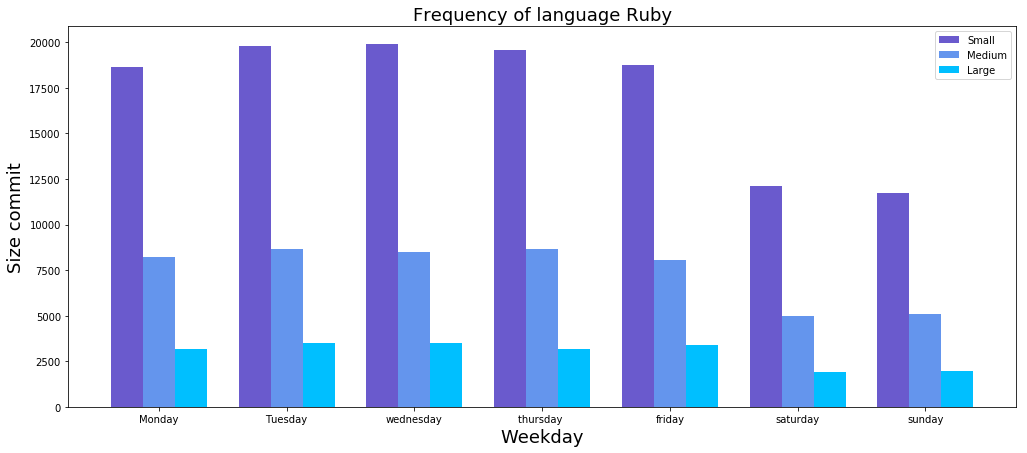

In [19]:
dataframe_l = size_project('ruby', 2)

dataframe_m = size_project('ruby', 3)

dataframe_h = size_project('ruby', 4)


weekday_low = weekday_frequency(dataframe_l)
weekday_medium = weekday_frequency(dataframe_m)
weekday_high = weekday_frequency(dataframe_h)

plot_bar(1, 'Ruby', weekday_low, weekday_medium, weekday_high)

<font size = 4/>
3.2.1 - Projetos Java 

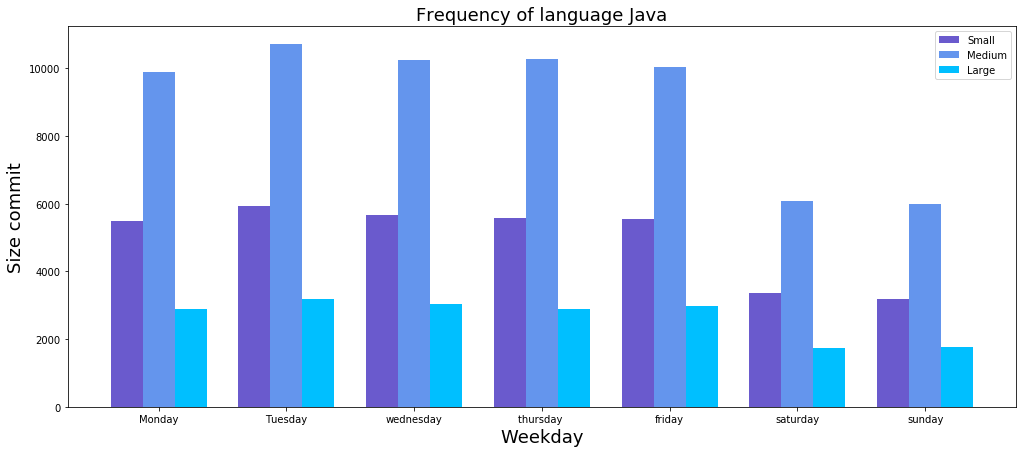

In [20]:
dataframe_l = size_project('java', 2)

dataframe_m = size_project('java', 3)

dataframe_h = size_project('java', 4)



weekday_low = weekday_frequency(dataframe_l)
weekday_medium = weekday_frequency(dataframe_m)
weekday_high = weekday_frequency(dataframe_h)

plot_bar(1, 'Java', weekday_low, weekday_medium, weekday_high)

<font size = 4/>
3.3 - Frequências de commit por Mês, por tamanho do projeto, pequeno, médio e grande.


<font size = 4/>
3.3.1 - Projetos RUBY 

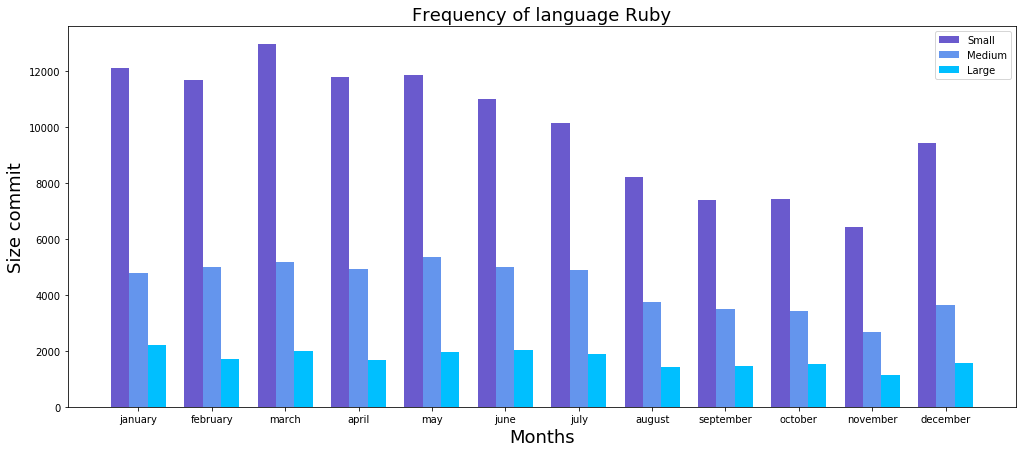

In [21]:
dataframe_l = size_project('ruby', 2)
dataframe_m = size_project('ruby', 3)
dataframe_h = size_project('ruby', 4)

month_low = month_frequency(dataframe_l)
month_medium = month_frequency(dataframe_m)
month_high = month_frequency(dataframe_h)

plot_bar(0, 'Ruby', month_low, month_medium, month_high)

<font size = 4/>
3.3.2 - Projetos Java 

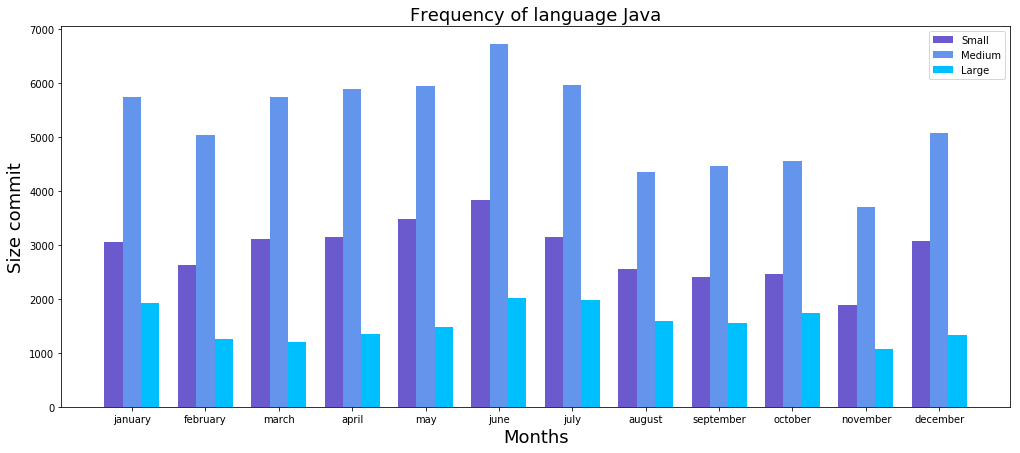

In [22]:
dataframe_l = size_project('java', 2)
dataframe_m = size_project('java', 3)
dataframe_h = size_project('java', 4)

month_low = month_frequency(dataframe_l)
month_medium = month_frequency(dataframe_m)
month_high = month_frequency(dataframe_h)

plot_bar(0, 'Java', month_low, month_medium, month_high)

In [23]:
dataframe = size_project('java', 2)
dt = dataframe.gh_pushed_at.dt.weekday.value_counts(normalize =True)
dt

1    0.170473
2    0.162621
3    0.160636
4    0.159716
0    0.158191
5    0.096324
6    0.092039
Name: gh_pushed_at, dtype: float64

<font size = 4/>
4 - Boxplot por semana e por mês

In [24]:
def plot_box(title, plot1, plot2, plot3=None, plot4=None, plot5=None, plot6=None, plot7=None, plot8=None, plot9=None, plot10=None, plot11=None, plot12=None):
    
    #if(plot3 == None):
    #    data=[plot1,plot2]
    if(plot8 == None):
        data=[plot1, plot2, plot3, plot4, plot5, plot6, plot7]
    else:
        data=[plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, plot10, plot11, plot12]
        
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.08, right=1.48, bottom=0.05, top=1.2,
                        hspace=0.4, wspace=0.3)

    ax.set_axisbelow(True)
    ax.set_title(title, size=20)
    ax.boxplot(data)

In [25]:
def commits_weekday(dataframe):
    weekday = [] 
    for i in range(0, 7):
        day = dataframe.loc[(dataframe.gh_pushed_at.dt.weekday == i)]
        weekday.append(day.gh_num_commits_in_push)
    return(weekday)

In [26]:
def commits_weekend(dataframe):
    weekday = []
    
    day = dataframe.loc[(dataframe.gh_pushed_at.dt.weekday < 5)]
    weekday.append(day.gh_num_commits_in_push)
    
    day_ = dataframe.loc[(dataframe.gh_pushed_at.dt.weekday >= 5)]
    weekday.append(day_.gh_num_commits_in_push)
    
    return(weekday)

In [27]:
dataframe_l = size_project('ruby', 2)
dataframe_m = size_project('ruby', 3)
dataframe_h = size_project('ruby', 4)


weekday_l = commits_weekday(dataframe)
#weekday_m = commits_weekday(dataframe_m)
#weekday_h = commits_weekday(dataframe_h)

#weekend_l = commits_weekend(dataframe_l)
#weekend_m = commits_weekend(dataframe_m)
#weekend_h = commits_weekend(dataframe_h)
#print('1: {} - 2: {} - 3: {} - 4: {} - 5: {} - 6:{} - 7: {}'.format(weekday[0], weekday[1], weekday[2], weekday[3], weekday[4], weekday[5], weekday[6]))


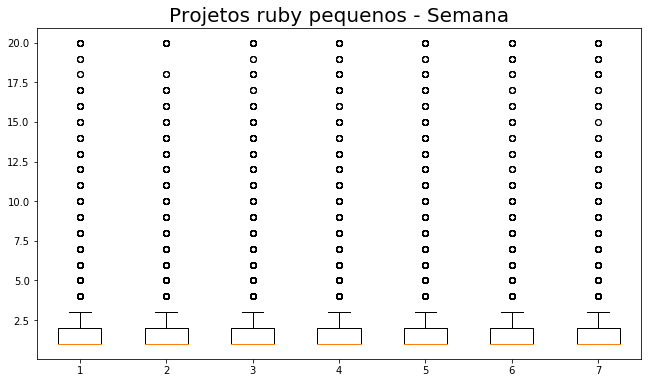

In [28]:
plot_box('Projetos ruby pequenos - Semana', weekday_l[0], weekday_l[1], weekday_l[2], weekday_l[3], weekday_l[4], weekday_l[5], weekday_l[6])
#plot_box('Projetos ruby médios - Semana', weekday_m[0], weekday_m[1], weekday_m[2], weekday_m[3], weekday_m[4], weekday_m[5], weekday_m[6])
#plot_box('Projetos ruby grandes - Semana', weekday_h[0], weekday_h[1], weekday_h[2], weekday_h[3], weekday_h[4], weekday_h[5], weekday_h[6])

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

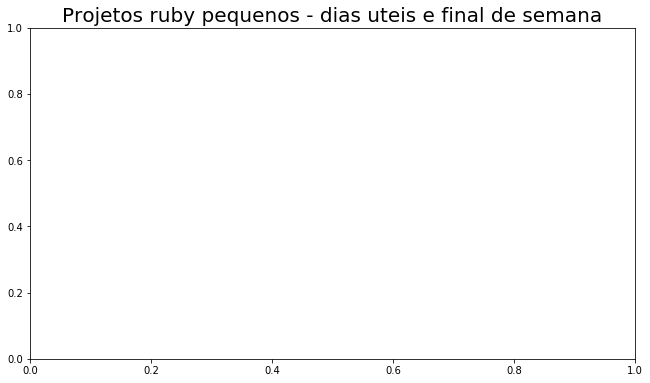

In [22]:
plot_box('Projetos ruby pequenos - dias uteis e final de semana', weekend_l[0], weekend_l[1])

In [ ]:
dataframe_l = size_project('java', 2)
dataframe_m = size_project('java', 3)
dataframe_h = size_project('java', 4)


weekday_l = commits_weekday(dataframe_l)
weekday_m = commits_weekday(dataframe_m)
weekday_h = commits_weekday(dataframe_h)
#print('1: {} - 2: {} - 3: {} - 4: {} - 5: {} - 6:{} - 7: {}'.format(weekday[0], weekday[1], weekday[2], weekday[3], weekday[4], weekday[5], weekday[6]))
plot_box('Projetos Java pequenos - Semana', weekday_l[0], weekday_l[1], weekday_l[2], weekday_l[3], weekday_l[4], weekday_l[5], weekday_l[6])
plot_box('Projetos Java médios - Semana', weekday_m[0], weekday_m[1], weekday_m[2], weekday_m[3], weekday_m[4], weekday_m[5], weekday_m[6])
plot_box('Projetos Java grandes - Semana', weekday_h[0], weekday_h[1], weekday_h[2], weekday_h[3], weekday_h[4], weekday_h[5], weekday_h[6])

<font size = 4/>
* 5 - Quantidade de Falhas por tamanho de projeto

In [6]:
test = dataset.loc[dataset['tr_log_bool_tests_failed'] == True]

test_fail = test.loc[test.gh_pushed_at.dt.weekday >= 5] # final de semana
test_day  = test.loc[test.gh_pushed_at.dt.weekday < 5] #  dia de semana
sext      = test.loc[test.gh_pushed_at.dt.weekday == 4] # sexta



print('Falha no teste na sexta: {}'.format(sext.tr_log_bool_tests_failed.sum()))
print('Falaha no teste seg à sex: {}'.format(test_day.tr_log_bool_tests_failed.sum()))
print('Falha no teste final de semana: {}'.format(test_fail.tr_log_bool_tests_failed.sum()))

Falha no teste na sexta: 19474
Falaha no teste seg à sex: 100598
Falha no teste final de semana: 24300
